<a href="https://colab.research.google.com/github/prakash-bisht/Reinforcement-Learning/blob/main/Reinforcement_Learning_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Shortcut Maze Environment.

In this maze environment, the goal is to reach the goal state (G) as fast as possible from the starting state (S). There are four actions – up, down, right, left – which take the agent deterministically from a state to the corresponding neighboring states, except when movement is blocked by a wall (denoted by grey) or the edge of the maze, in which case the agent remains where it is. The reward is +1 on reaching the goal state, 0 otherwise. On reaching the goal state G, the agent returns to the start state S to being a new episode. This is a discounted, episodic task with
.

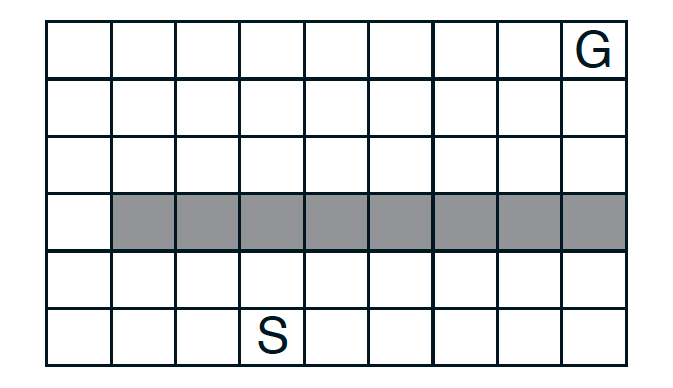

In [1]:
!pip install jdc

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, jdc, shutil
from tqdm import tqdm

from rl_glue import RLGlue
from agent import BaseAgent
from maze_env import ShortcutMazeEnvironment

#Dyna-Q

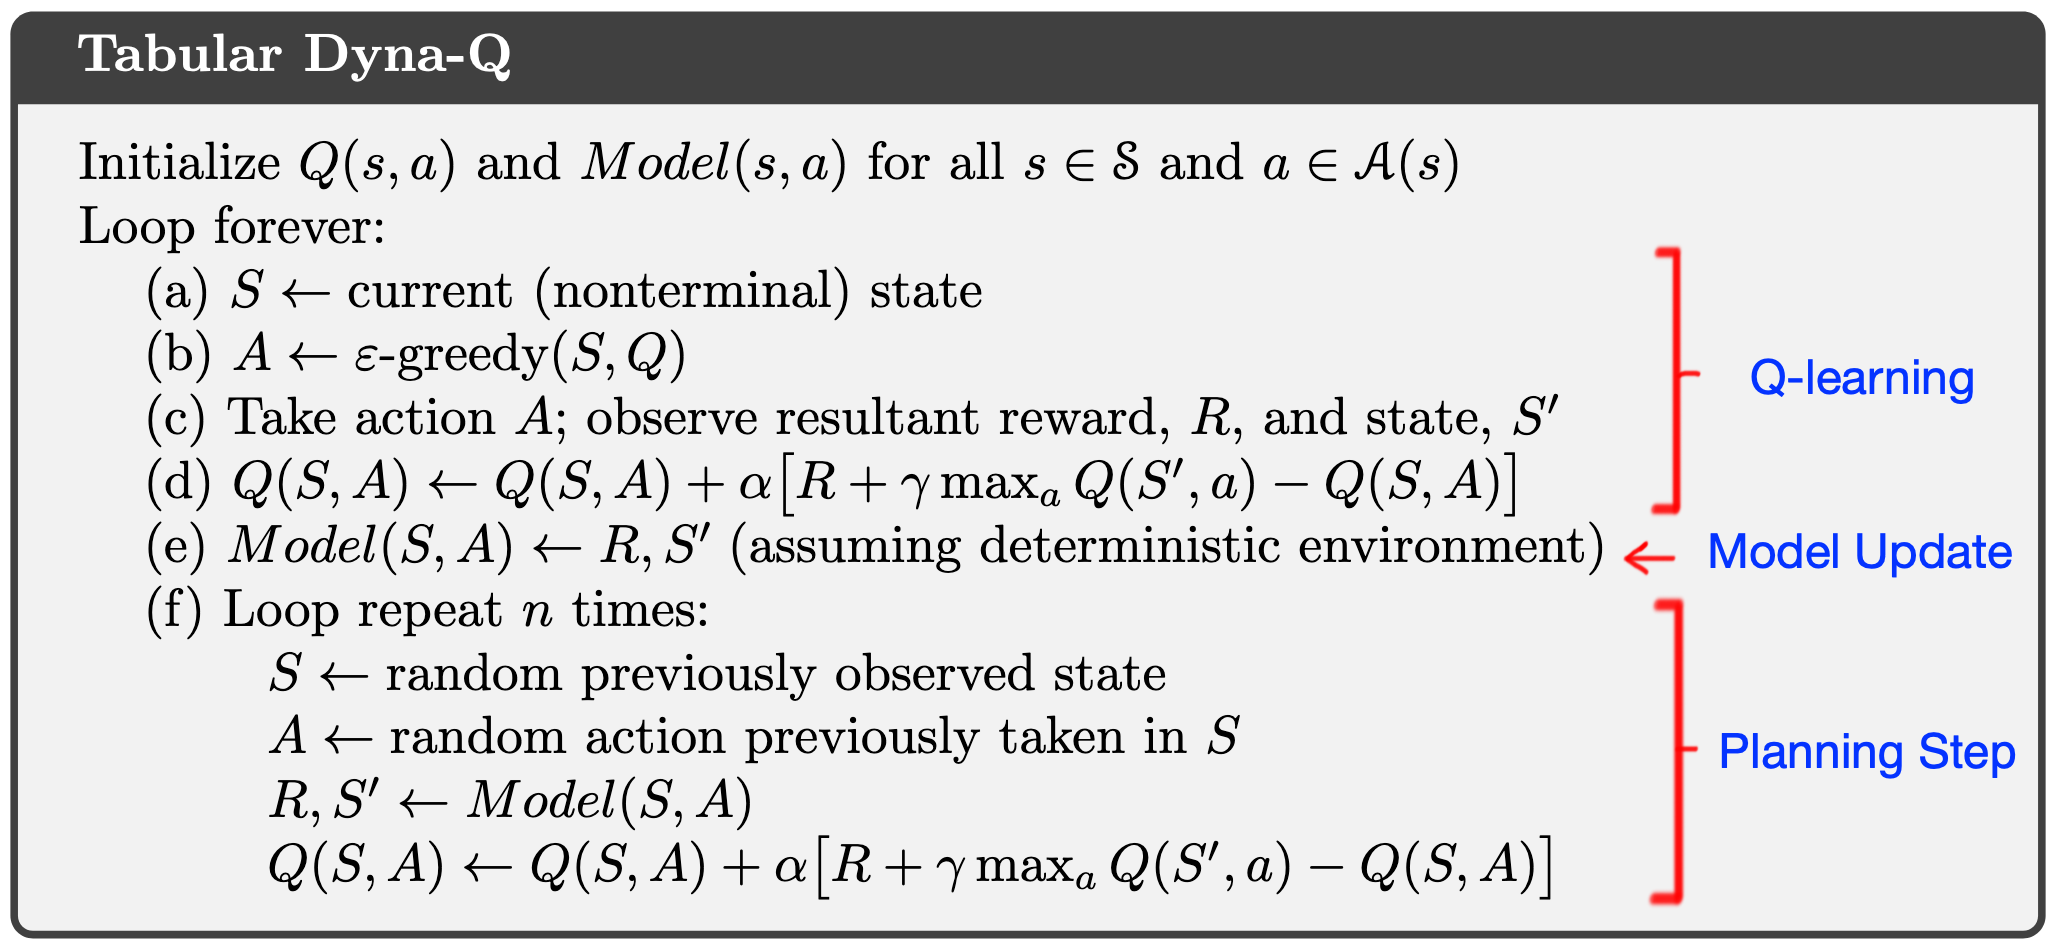

Dyna-Q involves four basic steps:

Action selection: given an observation, select an action to be performed (here, using the
-greedy method).

Direct RL: using the observed next state and reward, update the action values (here, using one-step tabular Q-learning).

Model learning: using the observed next state and reward, update the model (here, updating a table as the environment is assumed to be deterministic).

Planning: update the action values by generating
 simulated experiences using certain starting states and actions (here, using the random-sample one-step tabular Q-planning method). This is also known as the 'Indirect RL' step. The process of choosing the state and action to simulate an experience with is known as 'search control'.

In [2]:
class DynaQAgent(BaseAgent):

    def agent_init(self, agent_info):
        """Setup for the agent called when the experiment first starts.

        Args:
            agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
            {
                num_states (int): The number of states,
                num_actions (int): The number of actions,
                epsilon (float): The parameter for epsilon-greedy exploration,
                step_size (float): The step-size,
                discount (float): The discount factor,
                planning_steps (int): The number of planning steps per environmental interaction

                random_seed (int): the seed for the RNG used in epsilon-greedy
                planning_random_seed (int): the seed for the RNG used in the planner
            }
        """

        try:
            self.num_states = agent_info["num_states"]
            self.num_actions = agent_info["num_actions"]
        except:
            print("You need to pass both 'num_states' and 'num_actions' \
                   in agent_info to initialize the action-value table")
        self.gamma = agent_info.get("discount", 0.95)
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.planning_steps = agent_info.get("planning_steps", 10)

        self.rand_generator = np.random.RandomState(agent_info.get('random_seed', 42))
        self.planning_rand_generator = np.random.RandomState(agent_info.get('planning_random_seed', 42))

        self.q_values = np.zeros((self.num_states, self.num_actions))
        self.actions = list(range(self.num_actions))
        self.past_action = -1
        self.past_state = -1
        self.model = {}

In [3]:
%%add_to DynaQAgent
def update_model(self, past_state, past_action, state, reward):
    """updates the model

    Args:
        past_state       (int): s
        past_action      (int): a
        state            (int): s'
        reward           (int): r
    Returns:
        Nothing
    """
    if past_state not in self.model:
      self.model[past_state] = {}
    self.model[past_state][past_action] = (state,reward)

In [4]:
%%add_to DynaQAgent
def planning_step(self):
    """performs planning, i.e. indirect RL.

    Args:
        None
    Returns:
        Nothing
    """
    for i in range(self.planning_steps):
      past_state = self.planning_rand_generator.choice(list(self.model.keys()))
      past_action = self.planning_rand_generator.choice(list(self.model[past_state].keys()))
      state,reward = self.model[past_state][past_action]
      if state != -1:
        self.q_values[past_state][past_action] += self.step_size * (reward + self.gamma * np.max(self.q_values[state]) - self.q_values[past_state][past_action])
      else:
        self.q_values[past_state][past_action] += self.step_size * (reward - self.q_values[past_state][past_action])

In [5]:
%%add_to DynaQAgent
def argmax(self, q_values):
    """argmax with random tie-breaking
    Args:
        q_values (Numpy array): the array of action values
    Returns:
        action (int): an action with the highest value
    """
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return self.rand_generator.choice(ties)

def choose_action_egreedy(self, state):
    """returns an action using an epsilon-greedy policy w.r.t. the current action-value function.

    Important: assume you have a random number generator 'rand_generator' as a part of the class
                which you can use as self.rand_generator.choice() or self.rand_generator.rand()

    Args:
        state (List): coordinates of the agent (two elements)
    Returns:
        The action taken w.r.t. the aforementioned epsilon-greedy policy
    """

    if self.rand_generator.rand() < self.epsilon:
        action = self.rand_generator.choice(self.actions)
    else:
        values = self.q_values[state]
        action = self.argmax(values)

    return action

In [6]:
%%add_to DynaQAgent
def agent_start(self, state):
    """The first method called when the experiment starts,
    called after the environment starts.
    Args:
        state (Numpy array): the state from the
            environment's env_start function.
    Returns:
        (int) the first action the agent takes.
    """
    action = self.choose_action_egreedy(state)

    self.past_state = state
    self.past_action = action

    return self.past_action

def agent_step(self, reward, state):
    """A step taken by the agent.

    Args:
        reward (float): the reward received for taking the last action taken
        state (Numpy array): the state from the
            environment's step based on where the agent ended up after the
            last step
    Returns:
        (int) The action the agent takes given this state.
    """

    self.q_values[self.past_state][self.past_action] += self.step_size * (reward + self.gamma * np.max(self.q_values[state]) - self.q_values[self.past_state][self.past_action])
    self.update_model(self.past_state, self.past_action, state, reward)
    self.planning_step()
    action = self.choose_action_egreedy(state)

    self.past_state = state
    self.past_action = action

    return self.past_action

def agent_end(self, reward):
    """Called when the agent terminates.

    Args:
        reward (float): the reward the agent received for entering the
            terminal state.
    """

    self.q_values[self.past_state][self.past_action] += self.step_size * (reward - self.q_values[self.past_state][self.past_action])

    self.update_model(self.past_state, self.past_action, -1, reward)

    self.planning_step()

#Dyna-Q agent in the maze environment.



In [7]:
def run_experiment(env, agent, env_parameters, agent_parameters, exp_parameters):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_episodes = exp_parameters['num_episodes']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = env_parameters
    agent_info = {"num_states" : agent_parameters["num_states"],  # We pass the agent the information it needs.
                  "num_actions" : agent_parameters["num_actions"],
                  "epsilon": agent_parameters["epsilon"],
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    all_averages = np.zeros((len(planning_steps_all), num_runs, num_episodes)) # for collecting metrics
    log_data = {'planning_steps_all' : planning_steps_all}                     # that shall be plotted later

    for idx, planning_steps in enumerate(planning_steps_all):

        print('Planning steps : ', planning_steps)
        os.system('sleep 0.5')                    # to prevent tqdm printing out-of-order before the above print()
        agent_info["planning_steps"] = planning_steps

        for i in tqdm(range(num_runs)):

            agent_info['random_seed'] = i
            agent_info['planning_random_seed'] = i

            rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
            rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment

            for j in range(num_episodes):

                rl_glue.rl_start()                # We start an episode. Here we aren't using rl_glue.rl_episode()
                                                  # like the other assessments because we'll be requiring some
                is_terminal = False               # data from within the episodes in some of the experiments here
                num_steps = 0
                while not is_terminal:
                    reward, _, action, is_terminal = rl_glue.rl_step()  # The environment and agent take a step
                    num_steps += 1                                      # and return the reward and action taken.

                all_averages[idx][i][j] = num_steps

    log_data['all_averages'] = all_averages
    np.save("results/Dyna-Q_planning_steps", log_data)


def plot_steps_per_episode(file_path,allow_pickle=True):

    data = np.load(file_path).item()
    all_averages = data['all_averages']
    planning_steps_all = data['planning_steps_all']

    for i, planning_steps in enumerate(planning_steps_all):
        plt.plot(np.mean(all_averages[i], axis=0), label='Planning steps = '+str(planning_steps))

    plt.legend(loc='upper right')
    plt.xlabel('Episodes')
    plt.ylabel('Steps\nper\nepisode', rotation=0, labelpad=40)
    plt.axhline(y=16, linestyle='--', color='grey', alpha=0.4)
    plt.show()

In [9]:
# Experiment parameters
experiment_parameters = {
    "num_runs" : 30,                     # The number of times we run the experiment
    "num_episodes" : 40,                 # The number of episodes per experiment
}

# Environment parameters
environment_parameters = {
    "discount": 0.95,
}

# Agent parameters
agent_parameters = {
    "num_states" : 54,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [0, 5, 50]       # The list of planning_steps we want to try
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQAgent              # The agent

run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_steps_per_episode('results/Dyna-Q_planning_steps.npy',allow_pickle=True)
shutil.make_archive('results', 'zip', 'results');

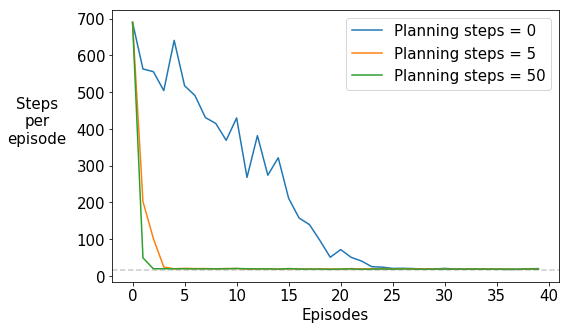

As the number of planning steps increases, the number of episodes taken to reach the goal decreases rapidly.

Note that the grey dotted line shows the minimum number of steps required to reach the goal state under the optimal greedy policy.

#Dyna-Q agent in the changing maze environment.

how Dyna-Q performs on the version of the maze in which a shorter path opens up after 3000 steps. The rest of the transition and reward dynamics remain the same.

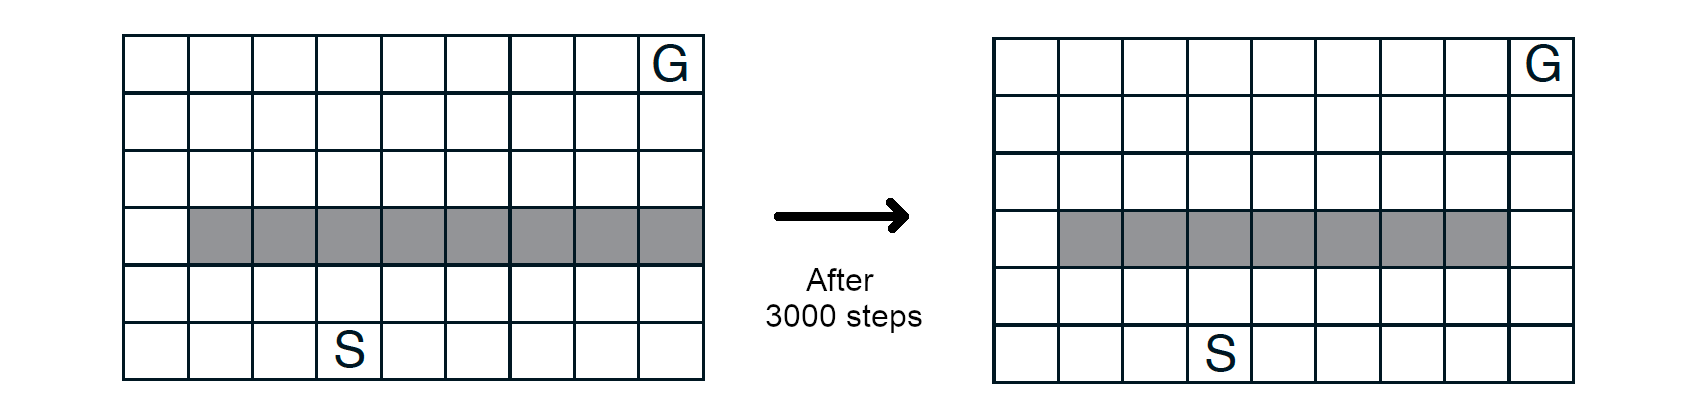

In [10]:
def run_experiment_with_state_visitations(env, agent, env_parameters, agent_parameters, exp_parameters, result_file_name):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_max_steps = exp_parameters['num_max_steps']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = {"change_at_n" : env_parameters["change_at_n"]}
    agent_info = {"num_states" : agent_parameters["num_states"],
                  "num_actions" : agent_parameters["num_actions"],
                  "epsilon": agent_parameters["epsilon"],
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    state_visits_before_change = np.zeros((len(planning_steps_all), num_runs, 54))  # For saving the number of
    state_visits_after_change = np.zeros((len(planning_steps_all), num_runs, 54))   #     state-visitations
    cum_reward_all = np.zeros((len(planning_steps_all), num_runs, num_max_steps))   # For saving the cumulative reward
    log_data = {'planning_steps_all' : planning_steps_all}

    for idx, planning_steps in enumerate(planning_steps_all):

        print('Planning steps : ', planning_steps)
        os.system('sleep 1')          # to prevent tqdm printing out-of-order before the above print()
        agent_info["planning_steps"] = planning_steps  # We pass the agent the information it needs.

        for run in tqdm(range(num_runs)):

            agent_info['random_seed'] = run
            agent_info['planning_random_seed'] = run

            rl_glue = RLGlue(env, agent)  # Creates a new RLGlue experiment with the env and agent we chose above
            rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment

            num_steps = 0
            cum_reward = 0

            while num_steps < num_max_steps-1 :

                state, _ = rl_glue.rl_start()  # We start the experiment. We'll be collecting the
                is_terminal = False            # state-visitation counts to visiualize the learned policy
                if num_steps < env_parameters["change_at_n"]:
                    state_visits_before_change[idx][run][state] += 1
                else:
                    state_visits_after_change[idx][run][state] += 1

                while not is_terminal and num_steps < num_max_steps-1 :
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    num_steps += 1
                    cum_reward += reward
                    cum_reward_all[idx][run][num_steps] = cum_reward
                    if num_steps < env_parameters["change_at_n"]:
                        state_visits_before_change[idx][run][state] += 1
                    else:
                        state_visits_after_change[idx][run][state] += 1

    log_data['state_visits_before'] = state_visits_before_change
    log_data['state_visits_after'] = state_visits_after_change
    log_data['cum_reward_all'] = cum_reward_all
    np.save("results/" + result_file_name, log_data)

def plot_cumulative_reward(file_path, item_key, y_key, y_axis_label, legend_prefix, title):

    data_all = np.load(file_path).item()
    data_y_all = data_all[y_key]
    items = data_all[item_key]

    for i, item in enumerate(items):
        plt.plot(np.mean(data_y_all[i], axis=0), label=legend_prefix+str(item))

    plt.axvline(x=3000, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel(y_axis_label, rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

In [11]:
# Experiment parameters
experiment_parameters = {
    "num_runs" : 10,                     # The number of times we run the experiment
    "num_max_steps" : 6000,              # The number of steps per experiment
}

# Environment parameters
environment_parameters = {
    "discount": 0.95,
    "change_at_n": 3000
}

# Agent parameters
agent_parameters = {
    "num_states" : 54,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.125,
    "planning_steps" : [5, 10, 50]      # The list of planning_steps we want to try
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQAgent              # The agent

run_experiment_with_state_visitations(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters, "Dyna-Q_shortcut_steps")
plot_cumulative_reward('results/Dyna-Q_shortcut_steps.npy', 'planning_steps_all', 'cum_reward_all', 'Cumulative\nreward', 'Planning steps = ', 'Dyna-Q : Varying planning_steps')

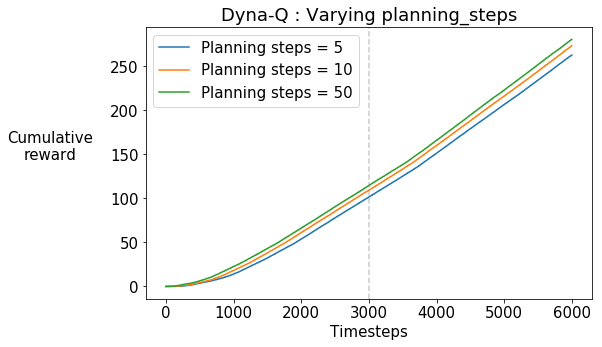

We observe that the slope of the curves is almost constant. If the agent had discovered the shortcut and begun using it, we would expect to see an increase in the slope of the curves towards the later stages of training. This is because the agent can get to the goal state faster and get the positive reward. Note that the timestep at which the shortcut opens up is marked by the grey dotted line.

Note that this trend is constant across the increasing number of planning steps.

In [12]:
def plot_state_visitations(file_path, plot_titles, idx):

    data = np.load(file_path).item()
    data_keys = ["state_visits_before", "state_visits_after"]
    positions = [211,212]
    titles = plot_titles
    wall_ends = [None,-1]

    for i in range(2):

        state_visits = data[data_keys[i]][idx]
        average_state_visits = np.mean(state_visits, axis=0)
        grid_state_visits = np.rot90(average_state_visits.reshape((6,9)).T)
        grid_state_visits[2,1:wall_ends[i]] = np.nan # walls
        #print(average_state_visits.reshape((6,9)))
        plt.subplot(positions[i])
        plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=1, cmap='viridis')
        plt.text(3+0.5, 0+0.5, 'S', horizontalalignment='center', verticalalignment='center')
        plt.text(8+0.5, 5+0.5, 'G', horizontalalignment='center', verticalalignment='center')
        plt.title(titles[i])
        plt.axis('off')
        cm = plt.get_cmap()
        cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([1., 0.0, 0.075, 1.])
    cbar = plt.colorbar(cax=cax)
    plt.show()

In [ ]:
plot_state_visitations("results/Dyna-Q_shortcut_steps.npy", ['Dyna-Q : State visitations before the env changes', 'Dyna-Q : State visitations after the env changes'], 1)

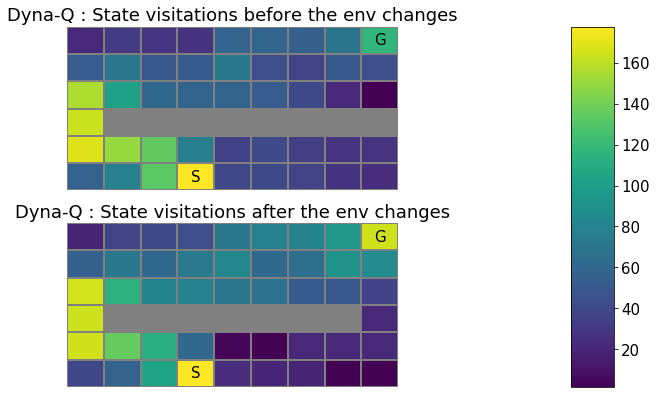

The state visitation map looks almost the same before and after the shortcut opens. This means that the Dyna-Q agent hasn't quite discovered and started exploiting the new shortcut.

Now let's try increasing the exploration parameter
 to see if it helps the Dyna-Q agent discover the shortcut.

In [14]:
def run_experiment_only_cumulative_reward(env, agent, env_parameters, agent_parameters, exp_parameters):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_max_steps = exp_parameters['num_max_steps']
    epsilons = agent_parameters['epsilons']

    env_info = {"change_at_n" : env_parameters["change_at_n"]}
    agent_info = {"num_states" : agent_parameters["num_states"],
                  "num_actions" : agent_parameters["num_actions"],
                  "planning_steps": agent_parameters["planning_steps"],
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    log_data = {'epsilons' : epsilons}
    cum_reward_all = np.zeros((len(epsilons), num_runs, num_max_steps))

    for eps_idx, epsilon in enumerate(epsilons):

        print('Agent : Dyna-Q, epsilon : %f' % epsilon)
        os.system('sleep 1')          # to prevent tqdm printing out-of-order before the above print()
        agent_info["epsilon"] = epsilon

        for run in tqdm(range(num_runs)):

            agent_info['random_seed'] = run
            agent_info['planning_random_seed'] = run

            rl_glue = RLGlue(env, agent)  # Creates a new RLGlue experiment with the env and agent we chose above
            rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment

            num_steps = 0
            cum_reward = 0

            while num_steps < num_max_steps-1 :

                rl_glue.rl_start()  # We start the experiment
                is_terminal = False

                while not is_terminal and num_steps < num_max_steps-1 :
                    reward, _, action, is_terminal = rl_glue.rl_step()  # The environment and agent take a step and return
                    # the reward, and action taken.
                    num_steps += 1
                    cum_reward += reward
                    cum_reward_all[eps_idx][run][num_steps] = cum_reward

    log_data['cum_reward_all'] = cum_reward_all
    np.save("results/Dyna-Q_epsilons", log_data)

In [ ]:
# Experiment parameters
experiment_parameters = {
    "num_runs" : 30,                     # The number of times we run the experiment
    "num_max_steps" : 6000,              # The number of steps per experiment
}

# Environment parameters
environment_parameters = {
    "discount": 0.95,
    "change_at_n": 3000
}

# Agent parameters
agent_parameters = {
    "num_states" : 54,
    "num_actions" : 4,
    "step_size" : 0.125,
    "planning_steps" : 10,
    "epsilons": [0.1, 0.2, 0.4, 0.8]    # The list of epsilons we want to try
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQAgent              # The agent

run_experiment_only_cumulative_reward(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_cumulative_reward('results/Dyna-Q_epsilons.npy', 'epsilons', 'cum_reward_all', 'Cumulative\nreward', r'$\epsilon$ = ', r'Dyna-Q : Varying $\epsilon$')

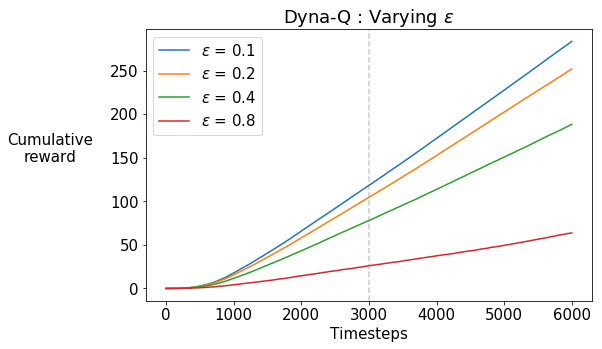

Increasing the exploration via the
episilon-greedy strategy does not seem to be helping. In fact, the agent's cumulative reward decreases because it is spending more and more time trying out the exploratory actions.

#Dyna-Q+

The motivation behind Dyna-Q+ is to give a bonus reward for actions that haven't been tried for a long time, since there is a greater chance that the dynamics for that actions might have changed.



In [15]:
class DynaQPlusAgent(BaseAgent):

    def agent_init(self, agent_info):
        """Setup for the agent called when the experiment first starts.

        Args:
            agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
            {
                num_states (int): The number of states,
                num_actions (int): The number of actions,
                epsilon (float): The parameter for epsilon-greedy exploration,
                step_size (float): The step-size,
                discount (float): The discount factor,
                planning_steps (int): The number of planning steps per environmental interaction
                kappa (float): The scaling factor for the reward bonus

                random_seed (int): the seed for the RNG used in epsilon-greedy
                planning_random_seed (int): the seed for the RNG used in the planner
            }
        """
        try:
            self.num_states = agent_info["num_states"]
            self.num_actions = agent_info["num_actions"]
        except:
            print("You need to pass both 'num_states' and 'num_actions' \
                   in agent_info to initialize the action-value table")
        self.gamma = agent_info.get("discount", 0.95)
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.planning_steps = agent_info.get("planning_steps", 10)
        self.kappa = agent_info.get("kappa", 0.001)

        self.rand_generator = np.random.RandomState(agent_info.get('random_seed', 42))
        self.planning_rand_generator = np.random.RandomState(agent_info.get('planning_random_seed', 42))

        self.q_values = np.zeros((self.num_states, self.num_actions))
        self.tau = np.zeros((self.num_states, self.num_actions))
        self.actions = list(range(self.num_actions))
        self.past_action = -1
        self.past_state = -1
        self.model = {}

In [16]:
%%add_to DynaQPlusAgent

# [GRADED]

def update_model(self, past_state, past_action, state, reward):
    """updates the model

    Args:
        past_state  (int): s
        past_action (int): a
        state       (int): s'
        reward      (int): r
    Returns:
        Nothing
    """
    if past_state not in self.model:
        self.model[past_state] = {past_action : (state, reward)}
        for action in self.actions:
            if action != past_action:
                self.model[past_state][action] = (past_state, 0)
    else:
        self.model[past_state][past_action] = (state, reward)

In [17]:
%%add_to DynaQPlusAgent

# [GRADED]

def planning_step(self):
    """performs planning, i.e. indirect RL.

    Args:
        None
    Returns:
        Nothing
    """
    for _ in range(self.planning_steps):
        past_state = self.planning_rand_generator.choice(list(self.model.keys()))
        past_action = self.planning_rand_generator.choice(list(self.model[past_state].keys()))
        state, reward = self.model[past_state][past_action]
        reward += self.kappa * np.sqrt(self.tau[past_state][past_action])
        if state != -1:
            self.q_values[past_state][past_action] += self.step_size * (reward + self.gamma * np.max(self.q_values[state]) - self.q_values[past_state][past_action])
        else:
            self.q_values[past_state][past_action] += self.step_size * (reward - self.q_values[past_state][past_action])


In [18]:
%%add_to DynaQPlusAgent
def argmax(self, q_values):
    """argmax with random tie-breaking
    Args:
        q_values (Numpy array): the array of action values
    Returns:
        action (int): an action with the highest value
    """
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return self.rand_generator.choice(ties)

def choose_action_egreedy(self, state):
    """returns an action using an epsilon-greedy policy w.r.t. the current action-value function.

    Important: assume you have a random number generator 'rand_generator' as a part of the class
                which you can use as self.rand_generator.choice() or self.rand_generator.rand()

    Args:
        state (List): coordinates of the agent (two elements)
    Returns:
        The action taken w.r.t. the aforementioned epsilon-greedy policy
    """

    if self.rand_generator.rand() < self.epsilon:
        action = self.rand_generator.choice(self.actions)
    else:
        values = self.q_values[state]
        action = self.argmax(values)

    return action

In [19]:
%%add_to DynaQPlusAgent
def agent_start(self, state):
    """The first method called when the experiment starts, called after
    the environment starts.
    Args:
        state (Numpy array): the state from the
            environment's env_start function.
    Returns:
        (int) The first action the agent takes.
    """
    action = self.choose_action_egreedy(state)

    self.past_state = state
    self.past_action = action

    return self.past_action

def agent_step(self, reward, state):
    """A step taken by the agent.
    Args:
        reward (float): the reward received for taking the last action taken
        state (Numpy array): the state from the
            environment's step based on where the agent ended up after the
            last step
    Returns:
        (int) The action the agent is taking.
    """

    self.tau += 1
    self.tau[self.past_state][self.past_action] = 0

    self.q_values[self.past_state][self.past_action] += self.step_size * (reward + self.gamma * np.max(self.q_values[state]) - self.q_values[self.past_state][self.past_action])

    self.update_model(self.past_state, self.past_action, state, reward)

    self.planning_step()

    action = self.choose_action_egreedy(state)

    self.past_state = state
    self.past_action = action

    return self.past_action

def agent_end(self, reward):
    """Called when the agent terminates.
    Args:
        reward (float): the reward the agent received for entering the
            terminal state.
    """
    self.tau += 1
    self.tau[self.past_state][self.past_action] = 0

    self.q_values[self.past_state][self.past_action] += self.step_size * (reward - self.q_values[self.past_state][self.past_action])

    self.update_model(self.past_state, self.past_action, -1, reward)

    self.planning_step()

#Dyna-Q+ agent in the changing environment.

In [ ]:
# Experiment parameters
experiment_parameters = {
    "num_runs" : 30,                     # The number of times we run the experiment
    "num_max_steps" : 6000,              # The number of steps per experiment
}

# Environment parameters
environment_parameters = {
    "discount": 0.95,
    "change_at_n": 3000
}

# Agent parameters
agent_parameters = {
    "num_states" : 54,
    "num_actions" : 4,
    "epsilon": 0.1,
    "step_size" : 0.5,
    "planning_steps" : [50]
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQPlusAgent          # The agent

run_experiment_with_state_visitations(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters, "Dyna-Q+")
shutil.make_archive('results', 'zip', 'results');

In [21]:
def plot_cumulative_reward_comparison(file_name_dynaq, file_name_dynaqplus):

    cum_reward_q = np.load(file_name_dynaq).item()['cum_reward_all'][2]
    cum_reward_qPlus = np.load(file_name_dynaqplus).item()['cum_reward_all'][0]

    plt.plot(np.mean(cum_reward_qPlus, axis=0), label='Dyna-Q+')
    plt.plot(np.mean(cum_reward_q, axis=0), label='Dyna-Q')

    plt.axvline(x=3000, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel('Cumulative\nreward', rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title('Average performance of Dyna-Q and Dyna-Q+ agents in the Shortcut Maze\n')
    plt.show()

In [22]:
plot_cumulative_reward_comparison('results/Dyna-Q_shortcut_steps.npy', 'results/Dyna-Q+.npy')

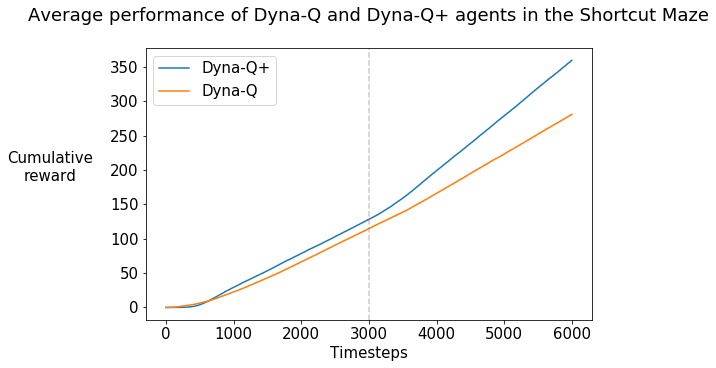

The slope of the curve increases for the Dyna-Q+ curve shortly after the shortcut opens up after 3000 steps, which indicates that the rate of receiving the positive reward increases. This implies that the Dyna-Q+ agent finds the shorter path to the goal.

In [23]:
plot_state_visitations("results/Dyna-Q+.npy", ['Dyna-Q+ : State visitations before the env changes', 'Dyna-Q+ : State visitations after the env changes'], 0)

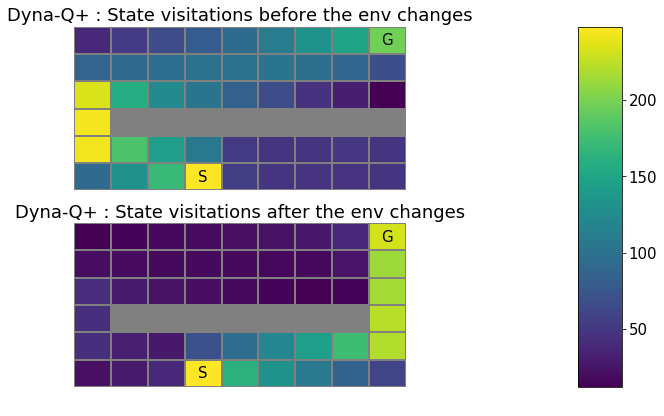

Before the shortcut opens up, like Dyna-Q, the Dyna-Q+ agent finds the sole, long path to the goal. But because the Dyna-Q+ agent keeps exploring, it succeeds in discovering the shortcut once it opens up, which leads to the goal faster. So the bonus reward heuristic is effective in helping the agent explore and find changes in the environment without degrading the performance.